# Clustering

## Agenda:

1. K-means clustering
2. Clustering evaluation
3. DBSCAN clustering

In [1]:
import pandas as pd
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (20.0, 6.0)

In [11]:
bikes = pd.read_csv('../data/2016-Q1-Trips-History-Data.csv')
bikes['start'] = pd.to_datetime(bikes['Start date'], infer_datetime_format=True)
bikes['end'] = pd.to_datetime(bikes['End date'], infer_datetime_format=True)
bikes['datetime_hour'] = bikes.start.dt.floor(freq='h')
bikes['hour'] = bikes.start.dt.hour
bikes['day_of_week'] = bikes.start.dt.dayofweek
bikes['member_cat'] = bikes['Member Type'].map({'Registered':0, 'Casual':1})
bikes_simp = bikes.drop(['Start date', 'End date', 'Start station', 
                         'End station', 'Bike number', 'start', 'end', 'datetime_hour', 'Member Type'], axis=1)
bikes_simp.dtypes

Duration (ms)           int64
Start station number    int64
End station number      int64
hour                    int64
day_of_week             int64
member_cat              int64
dtype: object

### Spatial Clustering

In [15]:
roads = pd.read_csv('../data/3D_spatial_network.txt', header=None, names=['osm', 'lat','lon','alt'])
roads
X = roads.drop(['osm'], axis=1)
X.head()

,lat,lon,alt
0,9.349849,56.740876,17.052772
1,9.350188,56.740679,17.614840
2,9.350549,56.740544,18.083536
3,9.350806,56.740484,18.279465
4,9.351053,56.740486,18.422974


What happened to y?

## Part 1: K-means clustering

In [10]:
# K-means with 3 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=1)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [12]:
# review the cluster labels
set(km.labels_)

{0, 1, 2}

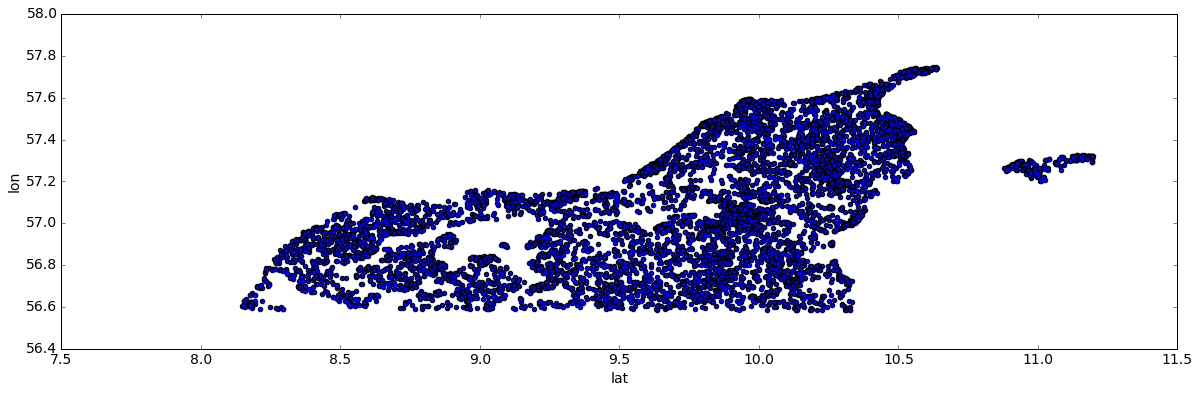

In [16]:
roads.sample(10000).plot(kind='scatter', x='lat', y='lon')

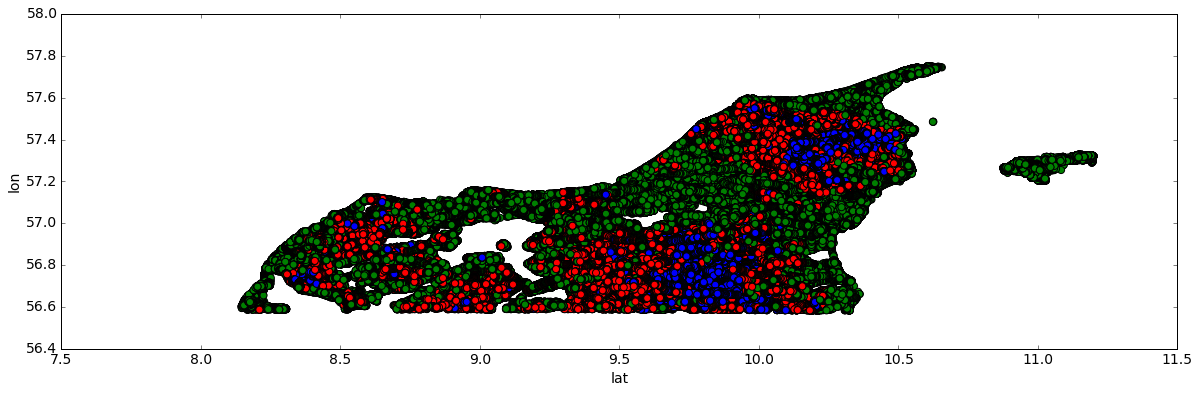

In [25]:
# create a "colors" array for plotting
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow'])

# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(X.lat, X.lon, c=colors[X.cluster], s=50)

# cluster centers, marked by "+"
# plt.scatter(centers.calories, centers.alcohol, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('lat')
plt.ylabel('lon')

In [12]:
# save the cluster labels and sort by cluster
X['cluster'] = km.labels_
X.groupby()

NameError: name 'km' is not defined

What do the clusters seem to be based on? Why?

In [6]:
# review the cluster centers
km.cluster_centers_

array([[ 150.        ,   17.        ,    4.52142857,    0.52071429],
       [ 102.75      ,   10.        ,    4.075     ,    0.44      ],
       [  70.        ,   10.5       ,    2.6       ,    0.42      ]])

In [7]:
# calculate the mean of each feature for each cluster
beer.groupby('cluster').mean()

,calories,sodium,alcohol,cost
cluster,,,,
0,150.00,17.0,4.521429,0.520714
1,102.75,10.0,4.075000,0.440000
2,70.00,10.5,2.600000,0.420000


In [8]:
# save the DataFrame of cluster centers
centers = beer.groupby('cluster').mean()

In [10]:
# create a "colors" array for plotting
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow'])

### Repeat with scaled data

In [13]:
# center and scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# K-means with 3 clusters on scaled data
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

What are the "characteristics" of each cluster?

Do you notice any cluster assignments that seem a bit odd? How might we explain those?

## Part 2: Clustering evaluation

The [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) is a common metric for evaluating clustering "performance" in situations when the "true" cluster assignments are not known.

A Silhouette Coefficient is calculated for **each observation**:

$$SC = \frac{b-a} {max(a, b)}$$

- a = mean distance to all other points in **its cluster**
- b = mean distance to all other points in **the next nearest cluster**

It ranges from -1 (worst) to 1 (best). A **global score** is calculated by taking the mean score for all observations.

In [ ]:
# calculate SC for K=3
from sklearn import metrics
metrics.silhouette_score(X, km.labels_)

In [19]:
# calculate SC for K=2 through K=19
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

c:\Users\alsherman\AppData\Local\Continuum\Anaconda\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


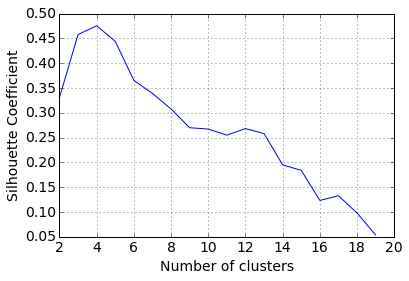

In [20]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [21]:
# K-means with 4 clusters on scaled data
km = KMeans(n_clusters=4, random_state=1)
km.fit(X_scaled)
beer['cluster'] = km.labels_
beer.sort('cluster')

,name,calories,sodium,alcohol,cost,cluster
0,Budweiser,144,15,4.7,0.43,0
1,Schlitz,151,19,4.9,0.43,0
17,Heilemans_Old_Style,144,24,4.9,0.43,0
16,Hamms,139,19,4.4,0.43,0
5,Old_Milwaukee,145,23,4.6,0.28,0
6,Augsberger,175,24,5.5,0.40,0
7,Srohs_Bohemian_Style,149,27,4.7,0.42,0
10,Coors,140,18,4.6,0.44,0
15,Pabst_Extra_Light,68,15,2.3,0.38,1
12,Michelob_Light,135,11,4.2,0.50,1


## Part 3: DBSCAN clustering

In [22]:
# DBSCAN with eps=1 and min_samples=3
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1, min_samples=3)
db.fit(X_scaled)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

In [23]:
# review the cluster labels
db.labels_

array([ 0,  0, -1,  1,  1, -1, -1,  0,  2,  2,  0,  2,  0, -1,  1, -1,  0,
        0, -1,  2], dtype=int64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001BBD6048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001F83EC50>]], dtype=object)

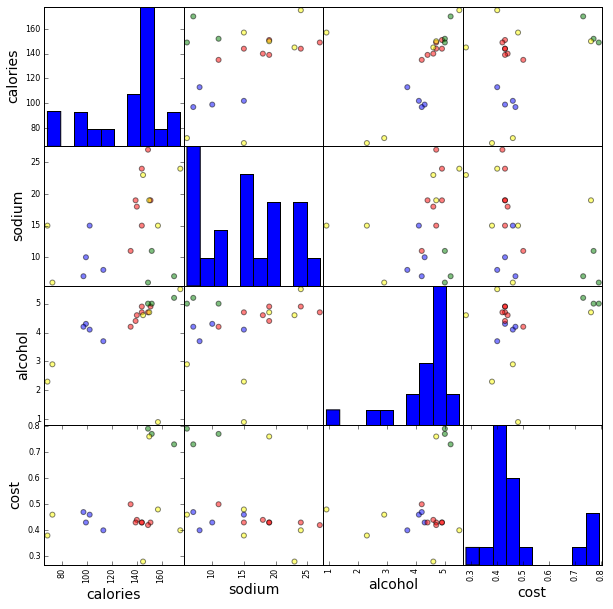

In [26]:
# scatter plot matrix of DBSCAN cluster assignments (0=red, 1=green, 2=blue, -1=yellow)
pd.scatter_matrix(X, c=colors[beer.cluster], figsize=(10,10), s=100)